# 1 - Retrieving, formating, and exploring the data

Mini-project for the 'Machine learning for NLP' course at ENSAE - May 2025

Paul Dupire and Floriane Zanella

## Installing and loading the necessary packages

In [ ]:
#!pip install seaborn

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tarfile
import urllib.request
import glob
import re
import math
from collections import Counter

## Retrieving the data from the provided webpage

In [10]:
# Downloading and extracting the IMDb Dataset

url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
filename = "aclImdb_v1.tar.gz"

if not os.path.exists("aclImdb"):
    urllib.request.urlretrieve(url, filename)
    with tarfile.open(filename, "r:gz") as tar:
        tar.extractall()
    print("Dataset downloaded and extracted.")

/tmp/ipykernel_929/393250052.py:9: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


Dataset downloaded and extracted.


In [11]:
# Creating our datasets (urls are there to identify the movies, and for further analysis of movie characteristics)

def create_datasets(dataset_type, polarity, base_path="aclImdb"):
    """    
    dataset_type: 'train' or 'test'
    polarity: 'pos' or 'neg'
    """
    review_path = os.path.join(base_path, dataset_type, polarity)
    url_file = os.path.join(base_path, dataset_type, f"urls_{polarity}.txt")
    
    # Loading review files into a list
    data = []
    for filepath in sorted(glob.glob(os.path.join(review_path, "*.txt"))):
        with open(filepath, "r", encoding="utf-8") as f:
            review_text = f.read()
        review_id, rating = os.path.basename(filepath).replace(".txt", "").split("_")
        label = 1 if polarity == "pos" else 0
        data.append((review_id, review_text, rating, label))
    
    # Creating a dataframe for the reviews
    df_reviews = pd.DataFrame(data, columns=["id_review", "review", "rating", "label"])

    # Loading URL files
    df_urls = pd.read_csv(url_file, header=None, names=['url'])
    df_urls['id_review'] = df_urls.index
    df_reviews['id_review'] = df_reviews['id_review'].astype(int)
    df_urls['id_review'] = df_urls['id_review'].astype(int)
    
    # Merge review data with URL data
    merged_df = pd.merge(df_reviews, df_urls, on="id_review", how="inner")
    
    return merged_df

# 4 subsets, as organized in the initial file
merged_train_neg = create_datasets(dataset_type="train", polarity="neg")
merged_train_pos = create_datasets(dataset_type="train", polarity="pos")
merged_test_neg = create_datasets(dataset_type="test", polarity="neg")
merged_test_pos = create_datasets(dataset_type="test", polarity="pos")

In [12]:
merged_train_neg.head()

,id_review,review,rating,label,url
0,0,Story of a man who has unnatural feelings for ...,3,0,http://www.imdb.com/title/tt0064354/usercomments
1,10000,Airport '77 starts as a brand new luxury 747 p...,4,0,http://www.imdb.com/title/tt0075648/usercomments
2,10001,This film lacked something I couldn't put my f...,4,0,http://www.imdb.com/title/tt0117050/usercomments
3,10002,"Sorry everyone,,, I know this is supposed to b...",1,0,http://www.imdb.com/title/tt0077742/usercomments
4,10003,When I was little my parents took me along to ...,1,0,http://www.imdb.com/title/tt0077742/usercomments


In [13]:
print(len(pd.unique(merged_test_neg['url']))) # number of movies in the negative part of the test set
len(merged_test_neg) # number of reviews in this dataset

3016


12500

In [14]:
test = pd.concat([merged_test_pos, merged_test_neg], ignore_index=True)
train = pd.concat([merged_train_pos, merged_train_neg], ignore_index=True)

In [15]:
# we shuffle the data in both datasets
test_df = test.sample(frac=1, random_state=42)
train_df = train.sample(frac=1, random_state=42)
test_df.head()

,id_review,review,rating,label,url
6868,4932,"When I was a kid, I loved ""Tiny Toons"". I espe...",10,1,http://www.imdb.com/title/tt0105598/usercomments
24016,9115,"The setup for ""Nature of the Beast"" is ingenio...",3,0,http://www.imdb.com/title/tt0113939/usercomments
9668,7452,I do not have much to say than this is a great...,10,1,http://www.imdb.com/title/tt0385700/usercomments
13640,11026,Extremely formulaic with cosmic-sized logic ho...,3,0,http://www.imdb.com/title/tt0031602/usercomments
14018,11367,I actually liked certain things about this gam...,4,0,http://www.imdb.com/title/tt0232532/usercomments


In [16]:
# Dealing with HTML tags
def remove_html_tags(text):
    clean_text = re.sub(r'<.*?>', '', text)  # removing any HTML tag (e.g., <br>, <div>, <p>, etc.)
    return clean_text

test_df["review"] = test_df["review"].apply(remove_html_tags)
train_df["review"] = train_df["review"].apply(remove_html_tags)

In [17]:
test_df['rating'] = test_df['rating'].astype(int)
train_df['rating'] = train_df['rating'].astype(int)

In [18]:
# Modification of URLs for the test set, the ending 'usercomments' is useless
test_df['url'] = test_df['url'].str.replace('usercomments', '', regex=False)
test_df['url'] = test_df['url'].str.replace('http://', 'https://', regex=False)

# Extracting the movie id on IMDb website using the URL
test_df['id_movie'] = test_df['url'].str.replace('https://www.imdb.com/title/', '', regex=False)
test_df['id_movie'] = test_df['id_movie'].str.replace('/', '', regex=False)

test_df.head(10)

,id_review,review,rating,label,url,id_movie
6868,4932,"When I was a kid, I loved ""Tiny Toons"". I espe...",10,1,https://www.imdb.com/title/tt0105598/,tt0105598
24016,9115,"The setup for ""Nature of the Beast"" is ingenio...",3,0,https://www.imdb.com/title/tt0113939/,tt0113939
9668,7452,I do not have much to say than this is a great...,10,1,https://www.imdb.com/title/tt0385700/,tt0385700
13640,11026,Extremely formulaic with cosmic-sized logic ho...,3,0,https://www.imdb.com/title/tt0031602/,tt0031602
14018,11367,I actually liked certain things about this gam...,4,0,https://www.imdb.com/title/tt0232532/,tt0232532
7488,5490,"I was watching the Perfect Storm, and thought ...",9,1,https://www.imdb.com/title/tt0107206/,tt0107206
5804,3975,"The best thing from the American Pie ""bakery.""...",10,1,https://www.imdb.com/title/tt0384793/,tt0384793
12909,10369,A severe backwards step for the puppets in thi...,4,0,https://www.imdb.com/title/tt0107899/,tt0107899
3386,1799,"""Valley Girl"" launched Nicolas Cage's career a...",9,1,https://www.imdb.com/title/tt0086525/,tt0086525
9567,7361,I cannot believe I enjoyed this as much as I d...,8,1,https://www.imdb.com/title/tt0115813/,tt0115813


In [19]:
# Modification of URLs for the train set, the ending 'usercomments' is useless
train_df['url'] = train_df['url'].str.replace('usercomments', '', regex=False)
train_df['url'] = train_df['url'].str.replace('http://', 'https://', regex=False)

# Extracting the movie id on IMDb website using the URL
train_df['id_movie'] = train_df['url'].str.replace('https://www.imdb.com/title/', '', regex=False)
train_df['id_movie'] = train_df['id_movie'].str.replace('/', '', regex=False)
train_df.head(10)

,id_review,review,rating,label,url,id_movie
6868,4932,In Panic In The Streets Richard Widmark plays ...,8,1,https://www.imdb.com/title/tt0042832/,tt0042832
24016,9115,If you ask me the first one was really better ...,1,0,https://www.imdb.com/title/tt0196267/,tt0196267
9668,7452,I am a big fan a Faerie Tale Theatre and I've ...,10,1,https://www.imdb.com/title/tt0575495/,tt0575495
13640,11026,I just finished reading a book about Dillinger...,1,0,https://www.imdb.com/title/tt0069976/,tt0069976
14018,11367,Greg Davis and Bryan Daly take some crazed sta...,2,0,https://www.imdb.com/title/tt0818682/,tt0818682
7488,5490,This really is an incredible film. Not only do...,9,1,https://www.imdb.com/title/tt0363940/,tt0363940
5804,3975,"If you lived through the 60s, this film can be...",10,1,https://www.imdb.com/title/tt0795102/,tt0795102
12909,10369,As a writer I find films this bad making it in...,1,0,https://www.imdb.com/title/tt0783501/,tt0783501
3386,1799,I'm 14 years old and I love this cartoon. Burt...,7,1,https://www.imdb.com/title/tt0096787/,tt0096787
9567,7361,This film would usually classify as the worst ...,10,1,https://www.imdb.com/title/tt0369946/,tt0369946


In [27]:
test_df.to_csv("test_df.csv", index=True)  # saving the test set in the working directory
train_df.to_csv("train_df.csv", index=True)  # saving the train set in the working directory

## Data exploration

In [29]:
# Combine train and test data to do some exploration of characteristics
full_df = pd.concat([train_df, test_df]).reset_index(drop=True)

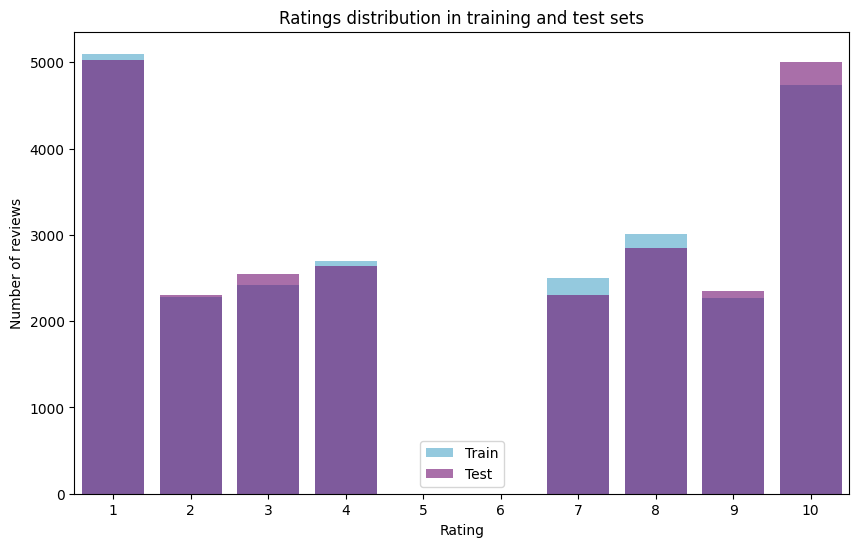

In [30]:
# True ratings distribution
plt.figure(figsize=(10, 6))

# Train set
sns.countplot(x="rating", data=train_df, color="skyblue", label="Train", order=range(1, 11))

# Test set
sns.countplot(x="rating", data=test_df, color="purple", label="Test", order=range(1, 11), alpha=0.6)

plt.xlabel("Rating")
plt.ylabel("Number of reviews")
plt.title("Ratings distribution in training and test sets")
plt.legend()
plt.show()

In [31]:
test_df.columns

Index(['id_review', 'review', 'rating', 'label', 'url', 'id_movie'], dtype='object')

In [32]:
full_df.columns

Index(['id_review', 'review', 'rating', 'label', 'url', 'id_movie'], dtype='object')

In [33]:
# How are the ratings contrasted on each movie ? Some statistics on ratings variance grouped by movies

# Variance of ratings per movie
rating_variance = full_df.groupby('id_movie')['rating'].var()

# Average variance
avg_variance = rating_variance.mean()

print(f"Average variance in ratings per movie: {avg_variance:.2f}")
print(rating_variance.describe())

Average variance in ratings per movie: 3.49
count    5641.000000
mean        3.491422
std         4.662456
min         0.000000
25%         0.666667
50%         1.500000
75%         4.500000
max        40.500000
Name: rating, dtype: float64


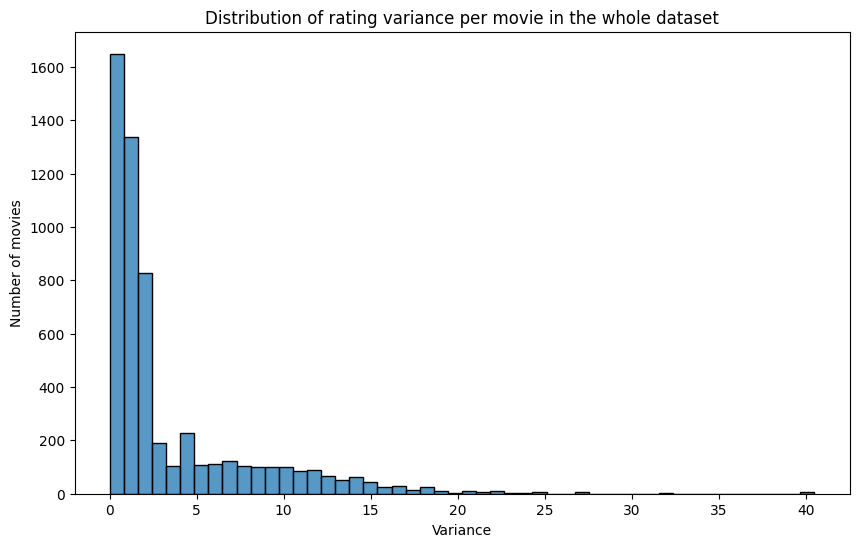

In [34]:
# Distribution of variances of ratings per movie
plt.figure(figsize=(10, 6))
sns.histplot(rating_variance, bins=50)
plt.title('Distribution of rating variance per movie in the whole dataset')
plt.xlabel('Variance')
plt.ylabel('Number of movies')
plt.show()

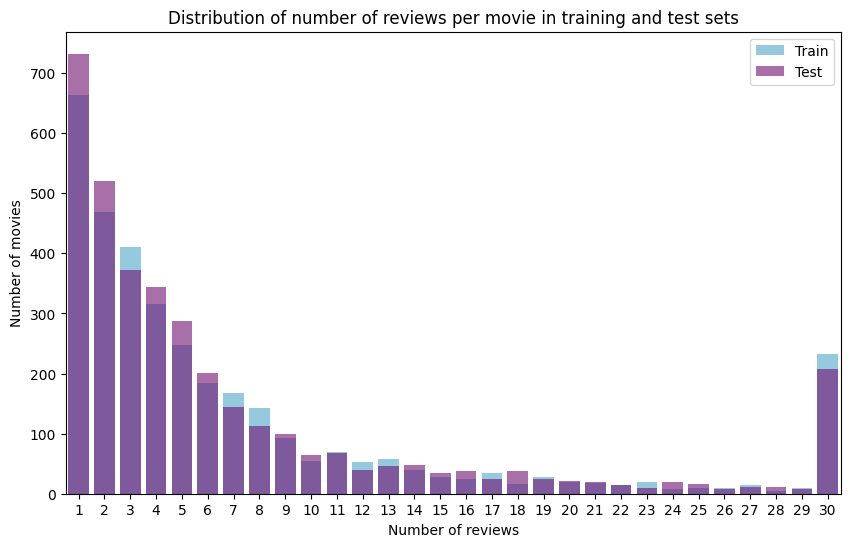

In [35]:
# Number of reviews per movie
# The creators of the dataset precised that there were no more than 30 reviews per movie in the whole dataset, we can verify that.

# Number of reviews per movie in each set
train_review_counts = train_df['id_movie'].value_counts().value_counts().sort_index()
test_review_counts = test_df['id_movie'].value_counts().value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=train_review_counts.index, y=train_review_counts.values, color='skyblue', label='Train')
sns.barplot(x=test_review_counts.index, y=test_review_counts.values, color='purple', alpha=0.6, label='Test')
plt.title('Distribution of number of reviews per movie in training and test sets')
plt.xlabel('Number of reviews')
plt.ylabel('Number of movies')
plt.legend()
plt.show()

In [36]:
# Clean and tokenize reviews
def clean_non_letters(text):
    text = re.sub(r"[^a-zA-Z']", " ",text) # remove non-letters
    text = text.lower()
    return text.strip().split()

# Tokenize all reviews and track lengths
tokenized_reviews = full_df['review'].apply(clean_non_letters)
review_lengths = tokenized_reviews.apply(len)


In [37]:
# Review length stats
avg_length = review_lengths.mean()
std_dev = review_lengths.std()

print(f"Total reviews: {len(full_df)}")
print(f"Average review length: {avg_length:.2f} words")
print(f"Standard deviation: {std_dev:.2f} words")

Total reviews: 50000
Average review length: 229.72 words
Standard deviation: 170.16 words


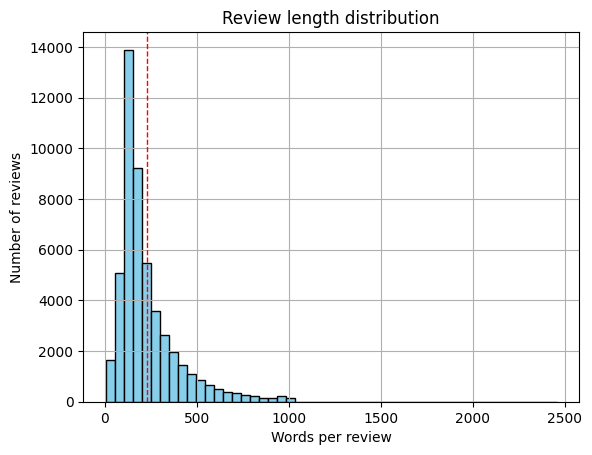

In [38]:
# Plot histogram of review lengths
plt.hist(review_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title("Review length distribution")
plt.xlabel("Words per review")
plt.ylabel("Number of reviews")
plt.axvline(avg_length, color='red',linestyle='dashed', linewidth=1)
plt.grid(True)
plt.show()

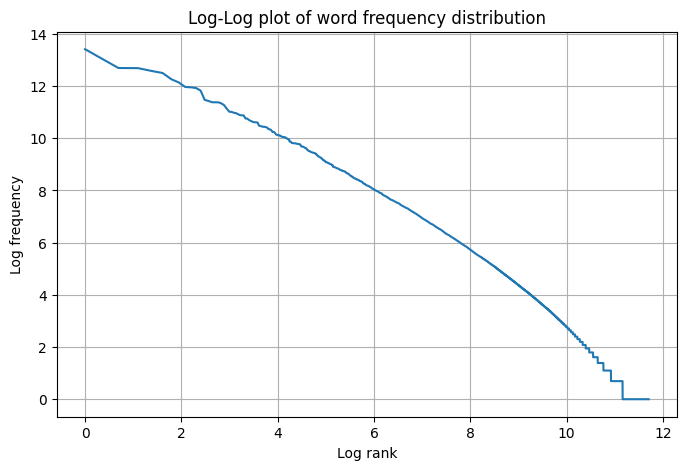

In [41]:
# Vocabulary distribution
vocab_counter = Counter()
for tokens in tokenized_reviews:
    vocab_counter.update(tokens)

# Convert vocab counter to list of frequencies
vocab_freqs = np.array(sorted(vocab_counter.values(),reverse=True))
ranks = np.arange(1, len(vocab_freqs) + 1)

# Plot log-log rank-frequency distribution
plt.figure(figsize=(8, 5))
plt.plot(np.log(ranks), np.log(vocab_freqs))
plt.title("Log-Log plot of word frequency distribution")
plt.xlabel("Log rank")
plt.ylabel("Log frequency")
plt.grid(True)
plt.show()

In [42]:
# Analyze long tail: how many words appear only once?
total_vocab = len(vocab_counter)

hapax_legomena = sum(1 for word,freq in vocab_counter.items() if freq == 1)

hapax_percent = 100 * hapax_legomena / total_vocab


print(f"Total unique words: {total_vocab}")
print(f"Words that appear only once: {hapax_legomena} ({hapax_percent:.2f}%)")

Total unique words: 121377
Words that appear only once: 50922 (41.95%)


In [43]:
# Look at top 20 frequent words (most are likely function words)
print("\nTop 20 most frequent words:")
for word, freq in vocab_counter.most_common(20):
    print(f"{word}: {freq}")


Top 20 most frequent words:
the: 666552
and: 324347
a: 322849
of: 289357
to: 268040
is: 211033
in: 186660
it: 156898
i: 154894
this: 150868
that: 136999
was: 95563
as: 91734
for: 87432
with: 87343
movie: 87030
but: 83524
film: 77671
on: 68018
not: 60705
